In [13]:
%pip install snntorch torch torchvision matplotlib tqdm

Note: you may need to restart the kernel to use updated packages.


### Task 1: Data Preprocessing (Spike Encoding)

#### 1.Download and preprocess the MNIST dataset.

+ Here I'm using SNNTORCH library developed by SNN researcher [Jason Eshraghian](https://www.jasoneshraghian.com/)

+ At first we'll import the required libraries

+ <span style="color:yellow"> Here the matplotlib.animation is added to visualize the spike trains later...
</span>


In [14]:
import snntorch as snn
import snntorch.functional as SF
import snntorch.surrogate as surrogate
from snntorch import spikegen
import torch.nn as nn
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.animation as animation

+ No GPU for me :P
and that won't matter mostly as SNN is a third gen computing and requires very low energy and is robust on CPU as well..
I'm using the Rate Method instead of temporal method. DOing Poisson rate encoding for 100 steps slows down the training process...

+ I've used random seed 42 (the classic..)

In [15]:
import numpy as np
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


>As mentioned earlier.. rate encoding steps are taken to be 10


 (more the merrier but training time increases dramatically)


the 60,000 MNIST image datasets would be trained in batches of 128


In [16]:
num_steps = 10
num_epochs=5       # Time steps for spike simulation
batch_size = 128
learning_rate = 1e-3
num_classes = 10 # constant for this problem.. classes being labels from 0 to 9 (both inclusive)


+ Here we are importing MNIST images dataset in .data folder for training (60,000) and testing (10,000)

+ I am using torch dataset and transforms provided by pytorch as it has the compose method which makes all the preprocessing code fit in one line

In [17]:
transform = transforms.Compose([transforms.ToTensor()])

train_data = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)


#### 2.Implement Poisson rate coding to convert pixel intensities into spike trains. Higher pixel intensities should correspond to higher firing rates.

>This is a crazy thing and crux of our model so We'll read and explain this carefully:

+ First of all we input images and num_steps to the function to give us a tensor 
'(num_steps,batch_size,1,28,28)'  
+ <span style="color:orange"><em>
This type of tensor size would make sense after visualizing it</em></span>
+ All it does is,
  + it input an image batch of batch size being primitive size of image tensor input.
 Hence we use `batch_size = images.shape[0]`
  + then for an image of size 28x28, it creates a tensor of size num_stepsx28x28 for each pixel in any image.. its intensity determines the rate at which a spike is fired (Again, if this is harder to grab.. see the visualization part)


In [18]:
def poisson_spike_encoding(images, num_steps=100):

    batch_size = images.shape[0]
    image_shape = images.shape[1:]
    
    rand_vals = torch.rand((num_steps, batch_size, *image_shape), device=images.device)
    spike_trains = rand_vals < images.unsqueeze(0)
    
    return spike_trains.float()


#### 3.Visualize sample input spike patterns for various digits to verify that encoding is working correctly.

**I have loaded an MNIST image of class 1  to give some insights**
Also I've plotted the cell grid in MNIST to 

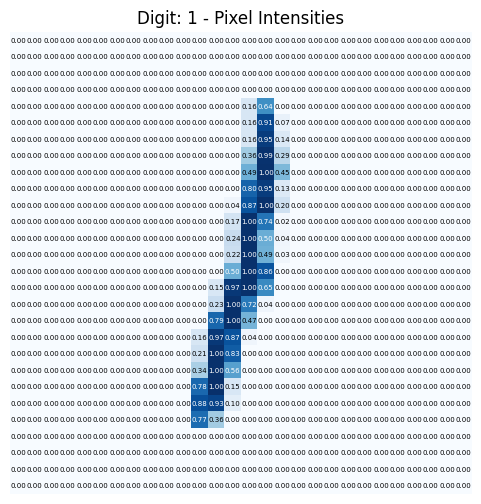

In [19]:
choice=1
dataiter = iter(train_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
zero_index = (labels == choice).nonzero(as_tuple=True)[0][0]
image_zero = images[zero_index].unsqueeze(0)  


fig, ax = plt.subplots(figsize=(6, 6))
image_data = image_zero[0, 0].cpu().numpy()
table = ax.imshow(image_data, cmap='Blues', vmin=0, vmax=1)

# Adding to show all the pixel values as text on a grid like strudcture
for i in range(28):
    for j in range(28):
        val = image_data[i, j]
        ax.text(j, i, f"{val:.2f}", ha="center", va="center",
                color="white" if val > 0.5 else "black", fontsize=5)

ax.set_title("Digit: 1 - Pixel Intensities")
ax.axis('off')
plt.show()

+ Loads digit 1 image from MNIST data set and performs poisson encoding on it..
+ We use digit 1 because most of bright pixels are located at middle column hence if we arrange the 28x28 array as a 1-D 784 array.. we get a bright pixel periodically with period 28..
+ Now when we plot the poisson spike train... we see the claim that for 10 time steps... the pixels after 150 fire almost always with period of 28 (as every 28th pixel is brigh in image of 1)

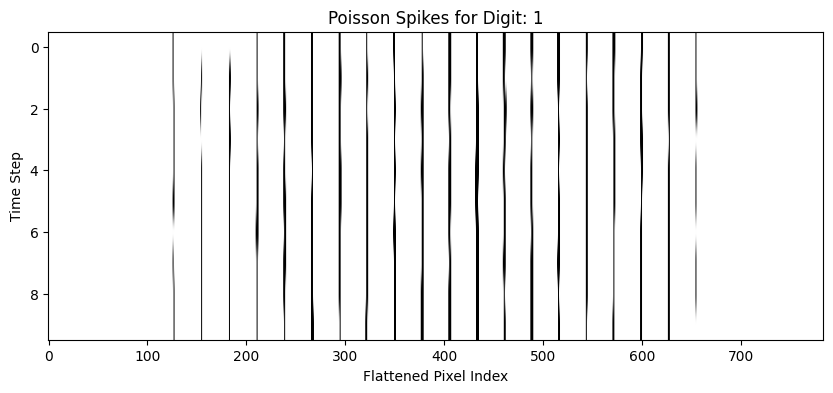

In [20]:
# Generate possion spikes for digit one
spike_trains = poisson_spike_encoding(image_zero, num_steps=num_steps)  # shape: (num_steps, 1, 1, 28, 28) as explained above

# Plot spike analysis for digit 1..
fig, ax = plt.subplots(figsize=(10, 4))
raster = spike_trains[:, 0, 0].reshape(num_steps, -1).cpu().numpy()
ax.imshow(raster, cmap='Greys', aspect='auto')
ax.set_title("Poisson Spikes for Digit: " + str(choice))
ax.set_xlabel("Flattened Pixel Index")
ax.set_ylabel("Time Step")
plt.show()


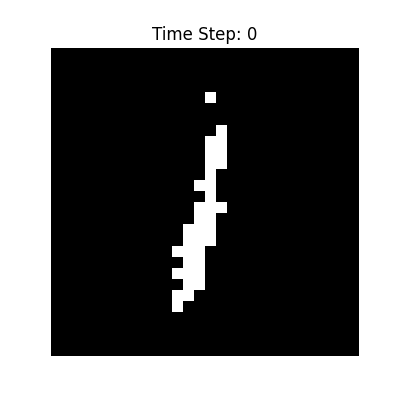

In [21]:
from IPython.display import Image, display

spikes = spike_trains[:, 0, 0].cpu().numpy()  # (num_steps, 28, 28)

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(spikes[0], cmap='gray', vmin=0, vmax=1)
ax.axis('off')

def update(t):
    im.set_array(spikes[t])
    ax.set_title(f'Time Step: {t}')
    return [im]

ani = animation.FuncAnimation(fig, update, frames=num_steps, interval=50, blit=True)

# Save GIF locally and also to display it in notebook
gif_path = "mnist_spike_flash.gif"
ani.save(gif_path, writer='pillow', fps=5)
plt.close(fig)

# display inline in notebook!
display(Image(filename=gif_path))

+ This is a simulation of how the network sees the image as spike table.. the boundary pixels flicker because their intensity is around 0.7-0.8 but the middle pixels never flicker as they are extremely bright and are fired everytime.

### Task 2: SNN Model Implementation (all done in same codeblock)

#### 1.Design a 3-layer SNN architecture:


We define a 3 layer SNN architecture having:
+ Input layer to recieve the spike trains.
+ Hidden Layer
+ Output layer(Corresponding to digit class 0-9)

#### 2.Implement the Leaky Integrate-and-Fire (LIF) neuron model

+ **Membrane potential dynamics with leakage**: snn.leaky models Leaky-Integrate-fire neurons where the potential across a membrane decays(leaks) if there is no input.

+ **Threshold-based spike generation**: 
    ```
    spk1, mem1 = self.lif1(cur1, mem1)
    spk2, mem2 = self.lif2(cur2, mem2)
    ```
    The spk1 and spk2 are binary values triggered to 1 only if threshold is crossed

+ **Reset mechanism after firing**: Implemented automatically in SNNtorch

+ **Learning method**: Supervised learning with surrogate gradients is used 

    `self.lif2 = snn.Leaky(beta=0.95, spike_grad=surrogate.fast_sigmoid())`

In [22]:

class SNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(28 * 28, 512)
        self.lif1 = snn.Leaky(beta=0.95, spike_grad=surrogate.fast_sigmoid()) # SNN torch enables us to do the encoding b/w layers and define forward later

        self.fc2 = nn.Linear(512, 10)
        self.lif2 = snn.Leaky(beta=0.95, spike_grad=surrogate.fast_sigmoid()) #Lif model implemented in SNNtorch

    def forward(self, x, num_steps=100):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk2_rec = []

        for step in range(num_steps):
            x_t = x[step]
            x_t = self.flatten(x_t)

            cur1 = self.fc1(x_t)
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk2_rec.append(spk2)

        return torch.stack(spk2_rec)

net = SNNModel().to(device)


### Task 3: Training and Evaluation

> I've came to know about tqdm to add progress bar into loops :P so why not use it!!

+ I've trained the SNN using Surrogate gradient descent
+ As a loss ftn I've used cross Entropy loss as it is good for classification problems. It implements the idea for probnability. Learn more on it [here!](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)


Epoch 1:   1%|          | 3/469 [00:00<00:16, 27.92it/s]

  Batch 0, Loss: 2.2984


Epoch 1:  23%|██▎       | 107/469 [00:02<00:07, 49.44it/s]

  Batch 100, Loss: 0.3509


Epoch 1:  45%|████▍     | 210/469 [00:04<00:05, 45.06it/s]

  Batch 200, Loss: 0.2324


Epoch 1:  65%|██████▌   | 306/469 [00:07<00:04, 39.32it/s]

  Batch 300, Loss: 0.1351


Epoch 1:  87%|████████▋ | 410/469 [00:09<00:01, 48.30it/s]

  Batch 400, Loss: 0.0567


Epoch 1: 100%|██████████| 469/469 [00:10<00:00, 44.72it/s]


Epoch 1 Completed — Avg Loss: 0.3168


Epoch 2:   1%|          | 4/469 [00:00<00:12, 37.74it/s]

  Batch 0, Loss: 0.1080


Epoch 2:  23%|██▎       | 108/469 [00:02<00:07, 47.35it/s]

  Batch 100, Loss: 0.1577


Epoch 2:  43%|████▎     | 204/469 [00:04<00:07, 36.14it/s]

  Batch 200, Loss: 0.1766


Epoch 2:  66%|██████▌   | 308/469 [00:06<00:03, 51.51it/s]

  Batch 300, Loss: 0.1053


Epoch 2:  86%|████████▌ | 404/469 [00:08<00:01, 53.97it/s]

  Batch 400, Loss: 0.1434


Epoch 2: 100%|██████████| 469/469 [00:10<00:00, 44.64it/s]


Epoch 2 Completed — Avg Loss: 0.1248


Epoch 3:   1%|          | 4/469 [00:00<00:13, 34.87it/s]

  Batch 0, Loss: 0.1229


Epoch 3:  23%|██▎       | 106/469 [00:01<00:06, 54.24it/s]

  Batch 100, Loss: 0.0550


Epoch 3:  45%|████▍     | 210/469 [00:04<00:04, 56.88it/s]

  Batch 200, Loss: 0.0910


Epoch 3:  67%|██████▋   | 312/469 [00:06<00:02, 54.51it/s]

  Batch 300, Loss: 0.0575


Epoch 3:  87%|████████▋ | 408/469 [00:07<00:01, 58.11it/s]

  Batch 400, Loss: 0.1034


Epoch 3: 100%|██████████| 469/469 [00:08<00:00, 53.15it/s]


Epoch 3 Completed — Avg Loss: 0.0954


Epoch 4:   1%|          | 5/469 [00:00<00:10, 44.55it/s]

  Batch 0, Loss: 0.0862


Epoch 4:  22%|██▏       | 103/469 [00:01<00:06, 57.72it/s]

  Batch 100, Loss: 0.0944


Epoch 4:  45%|████▍     | 210/469 [00:03<00:04, 57.88it/s]

  Batch 200, Loss: 0.0579


Epoch 4:  67%|██████▋   | 312/469 [00:05<00:02, 55.80it/s]

  Batch 300, Loss: 0.1390


Epoch 4:  87%|████████▋ | 408/469 [00:07<00:01, 48.92it/s]

  Batch 400, Loss: 0.0652


Epoch 4: 100%|██████████| 469/469 [00:08<00:00, 53.69it/s]


Epoch 4 Completed — Avg Loss: 0.0770


Epoch 5:   1%|          | 5/469 [00:00<00:10, 43.29it/s]

  Batch 0, Loss: 0.0977


Epoch 5:  23%|██▎       | 110/469 [00:02<00:07, 45.31it/s]

  Batch 100, Loss: 0.0616


Epoch 5:  44%|████▍     | 208/469 [00:04<00:05, 46.29it/s]

  Batch 200, Loss: 0.0591


Epoch 5:  66%|██████▌   | 308/469 [00:07<00:03, 43.77it/s]

  Batch 300, Loss: 0.0551


Epoch 5:  87%|████████▋ | 408/469 [00:09<00:01, 43.99it/s]

  Batch 400, Loss: 0.0578


Epoch 5: 100%|██████████| 469/469 [00:11<00:00, 42.10it/s]


Epoch 5 Completed — Avg Loss: 0.0671


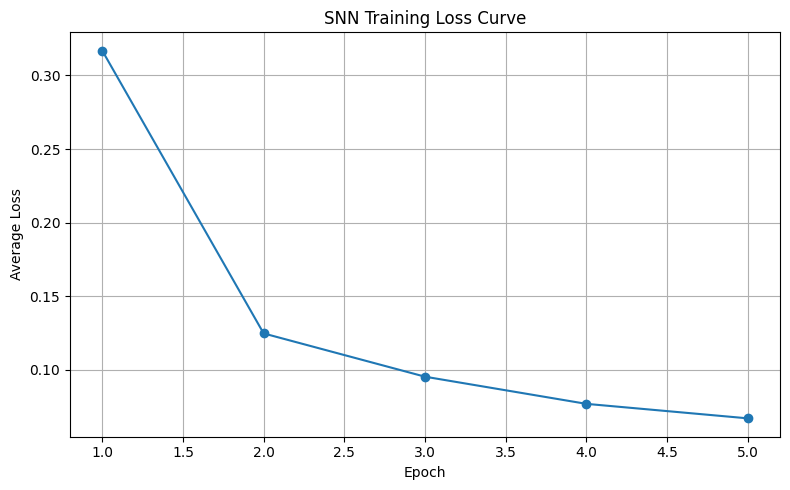

In [23]:
from tqdm import tqdm


optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()


loss_history = []

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        images = images.to(device)
        labels = labels.to(device)

        
        spk_in = poisson_spike_encoding(images, num_steps=num_steps)  

       
        spk_out = net(spk_in, num_steps=num_steps)  

        
        spk_out_count = spk_out.sum(dim=0)

        #Loss computation (Cross Entropy expects raw scoores with integer labels and is good for classification)
        loss_val = loss_fn(spk_out_count, labels)

        #Backprop
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        running_loss += loss_val.item()

        if i % 100 == 0:
            print(f"  Batch {i}, Loss: {loss_val.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1} Completed — Avg Loss: {avg_loss:.4f}")

# Ploting the training loss --- Assumed to follow a decaying convex up curve for good model (source D2L.ai)
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), loss_history, marker='o', linestyle='-')
plt.title("SNN Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


+ Training for 5 epochs only gave good progress.. similar to ANN (97.5% accuray) even without neuromorphic hardware.

In [24]:
def evaluate(net, test_loader, num_steps=100):
    net.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            spk_in = poisson_spike_encoding(images, num_steps)
            spk_out = net(spk_in, num_steps)
            spk_out_count = spk_out.sum(dim=0)

            predicted = spk_out_count.argmax(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    print(f"Test Accuracy: {acc:.2f}%")

evaluate(net, test_loader)


Test Accuracy: 97.16%


### Takeaways:

+ Despite SNN being theoretically better than ANN, we say how SNN performs almost similar to ANN in terms of speed and accuracy and power draw.
+ However this is a good thing that even without neuormorphic chips (native for SNN), we get such good performance
+ This practice helps us understand how our real brain works on such low power (our brain is neuromorphically modified)

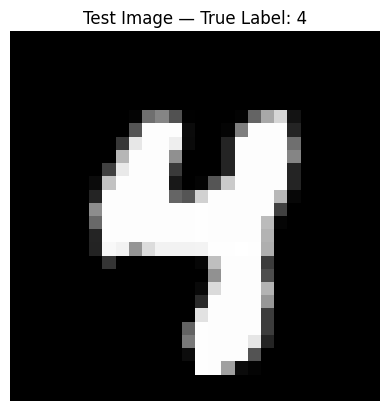

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Video, display
import random


images, labels = next(iter(test_loader))
idx = random.randint(0, images.shape[0] - 1)
test_img = images[idx].unsqueeze(0).to(device) 
true_label = labels[idx].item()

# Display the selected one test image
plt.imshow(test_img.squeeze().cpu(), cmap='gray')
plt.title(f"Test Image — True Label: {true_label}")
plt.axis('off')
plt.show()

# Poisson encode the test image to pass it in the SNN model
test_spikes = poisson_spike_encoding(test_img, num_steps=100)  # [nuim_steps, 1, 1, 28, 28]

# Running through SNN
spk_rec = net(test_spikes.to(device), num_steps=100).squeeze(1).detach().cpu()  

# Spike count animation(found this snippet in a kaggle notebook)
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(range(10), [0]*10, tick_label=list(range(10)))
ax.set_ylim(0, 250)  
ax.set_title(f"Spike Activity Over Time — True Label: {true_label}")
ax.set_ylabel("Spike Count")
ax.set_xlabel("Class")

def update(frame):
    for i, b in enumerate(bars):
        b.set_height(spk_rec[:frame+1, i].sum().item())
    return bars

ani = animation.FuncAnimation(fig, update, frames=100, blit=False, interval=100)

# Save & Display Inline
video_path = "spike_activity.mp4"
ani.save(video_path, writer='ffmpeg', fps=5)
plt.close()
display(Video(video_path, embed=True))


+ This tool for visualization was inspired by [this notebook!](https://www.kaggle.com/code/khoahongg/classify-n-mnist-with-spiking-neural-network/notebook)

+ Try running this block without training the model (i.e at 11% accuracy) as well :P

+ We see that we recieve output spikes for other labels as well (apart from true label) as our true digit is partly similar to other digits as well

### Resources used:

1. I came to know of SNN through a video of Jason Eshraghian (Lead developer of SNN torch). I've self curated a [playlist](https://www.youtube.com/playlist?list=PLtO_DmDV5KcVWKdvM8ZEx_eti4dkX0lrt) of his tutorial to use SNNtorch.

    + The extremely well curated [documentation of SNNtorch](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)

2. To understand the difference b/w ANN and SNN, the 3 types of harwares chronologically used in ML (neuromorphic being the latest) I highly recommed [this paper](https://oshears.github.io/adv-ml-2020-snn-project/report/Advanced_Machine_Learning_Project_Report.pdf) by 

